In [1]:
import warnings
warnings.filterwarnings("ignore")

import read_data as imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
import pyfolio

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def find_median(x):
    aux = [0 for k in range(x.shape[0])]
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            aux[i] += np.linalg.norm(x.iloc[i,]-x.iloc[j,])
    return x.iloc[aux == min(aux),].iloc[0,]

In [3]:
base = 252

symbols = ['XLP','XLY','XLE','XLF','XLV','XLI','XLK','XLU']
years = [x for x in range(2000,2019)]
hist_data = imp.organizarTodo(symbols,years)

Daily_Assets = pd.DataFrame()
Daily_Log_Assets = pd.DataFrame()

for asset,df in hist_data.items():
    Daily_Assets[asset] = df['Close']
    Daily_Log_Assets[asset] = np.log(df['Close']/df['Close'].shift(1))
#     Daily_Log_Assets[asset] = df['Close']/df['Close'].shift(1)-1

In [4]:
Assets = pd.read_csv('Data.csv')
Assets.set_index('Date', inplace=True)
Assets.index = pd.to_datetime(Assets.index)
Log_Assets = np.log(Assets/Assets.shift(1))
Log_Assets = Log_Assets.dropna()

In [5]:
np.random.seed(42)

T_N = 6
the_start = np.where(Daily_Assets.index == Log_Assets.index[T_N])[0][0]

com = 0.0015
BidAskSpread = 0.00016

In [6]:
Mark_Ret = np.zeros(Daily_Assets.shape[0]-the_start)
RMark_Ret = np.zeros(Daily_Assets.shape[0]-the_start)
R2Mark_Ret = np.zeros(Daily_Assets.shape[0]-the_start)

Curr_Wi = np.zeros(len(Assets.columns))
RCurr_Wi = np.zeros(len(Assets.columns))
R2Curr_Wi = np.zeros(len(Assets.columns))

WC = pd.DataFrame(index=Log_Assets.index, columns= Log_Assets.columns)
WR = pd.DataFrame(index=Log_Assets.index, columns= Log_Assets.columns)
WR2 = pd.DataFrame(index=Log_Assets.index, columns= Log_Assets.columns)

indaux = T_N

for i in range(the_start, Daily_Assets.shape[0]):
        
    if Daily_Assets.index[i] in Log_Assets.index:
        
        # Classic
        mu = base * Log_Assets.iloc[indaux-T_N:indaux,:].mean()
        S = base * Log_Assets.iloc[indaux-T_N:indaux,:].cov()

        ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
        ef.max_sharpe()
        Curr_Wi = np.array([x for y,x in ef.clean_weights().items()])
        
        # Margin Median
        mu = base * Log_Assets.iloc[indaux-T_N:indaux,:].median()
        LW_Cov = LedoitWolf().fit(Log_Assets.iloc[indaux-T_N:indaux,:]).covariance_
        S = base * LW_Cov

        ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
        ef.max_sharpe()
        RCurr_Wi = np.array([x for y,x in ef.clean_weights().items()])
        
        # Indicator Median
        mu = base * find_median(Log_Assets.iloc[indaux-T_N:indaux,:])
        LW_Cov = LedoitWolf().fit(Log_Assets.iloc[indaux-T_N:indaux,:]).covariance_
        S = base * LW_Cov

        ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
        ef.max_sharpe()
        R2Curr_Wi = np.array([x for y,x in ef.clean_weights().items()])
        
        # Saving Weights
        
        WC.iloc[indaux,] = Curr_Wi
        WR.iloc[indaux,] = RCurr_Wi
        WR2.iloc[indaux,] = R2Curr_Wi
        
        Mark_Ret[i-the_start] = np.dot(Daily_Log_Assets.iloc[i,],Curr_Wi)*(1-com)*(1-BidAskSpread)
        RMark_Ret[i-the_start] = np.dot(Daily_Log_Assets.iloc[i,],RCurr_Wi)*(1-com)*(1-BidAskSpread)
        R2Mark_Ret[i-the_start] = np.dot(Daily_Log_Assets.iloc[i,],R2Curr_Wi)*(1-com)*(1-BidAskSpread)
        
        indaux += 1
    else:
        Mark_Ret[i-the_start] = np.dot(Daily_Log_Assets.iloc[i,],Curr_Wi)
        RMark_Ret[i-the_start] = np.dot(Daily_Log_Assets.iloc[i,],RCurr_Wi)
        R2Mark_Ret[i-the_start] = np.dot(Daily_Log_Assets.iloc[i,],R2Curr_Wi)

## Weights Behivor

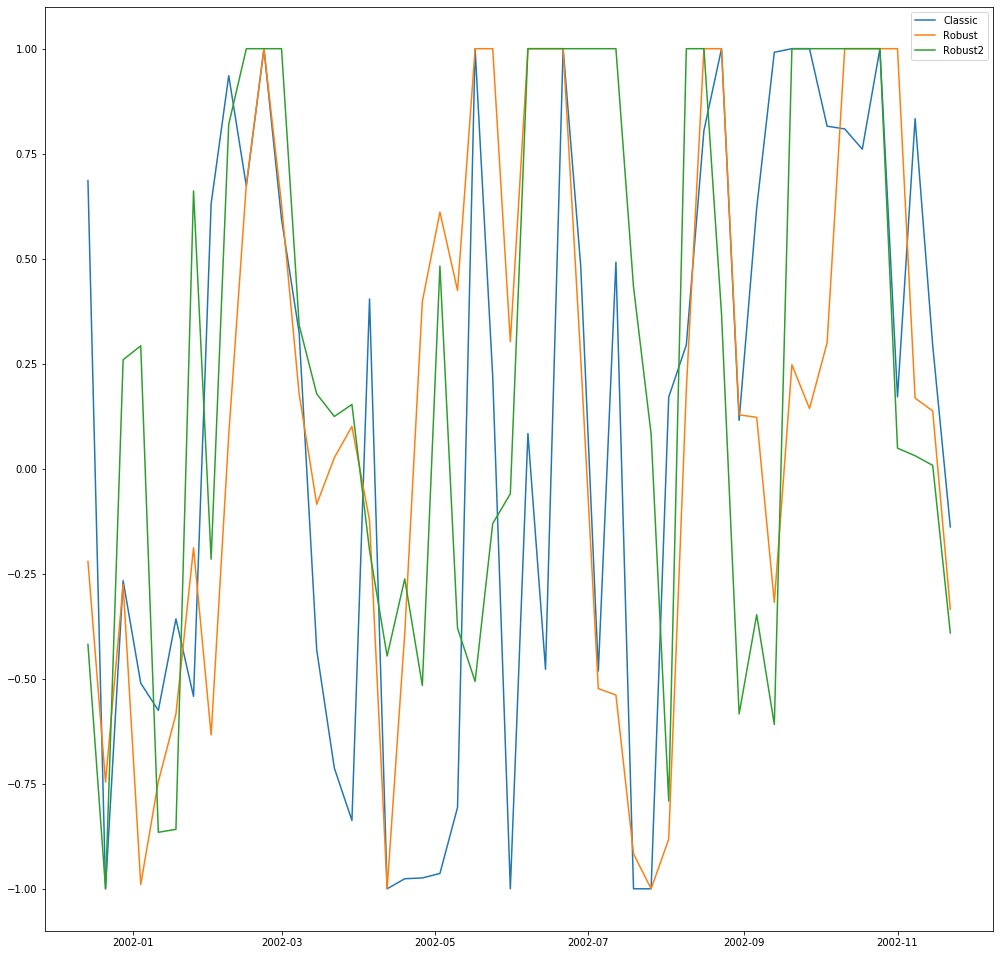

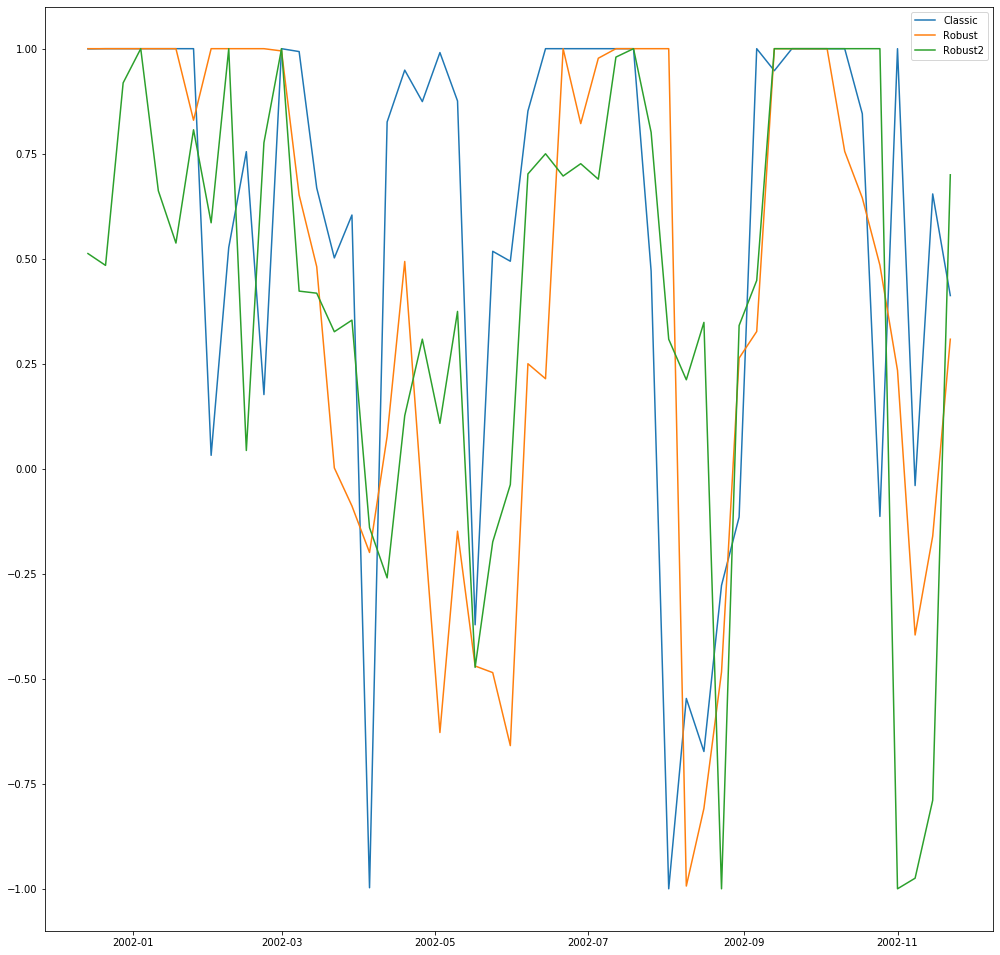

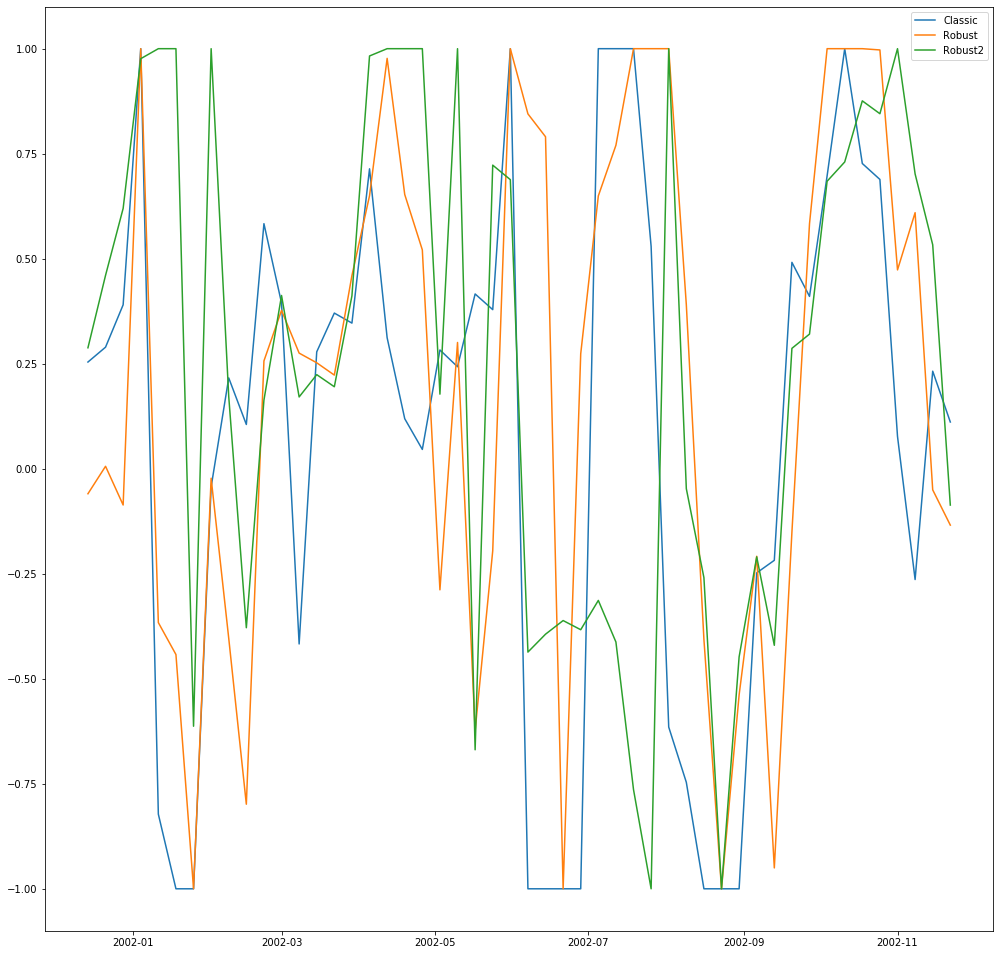

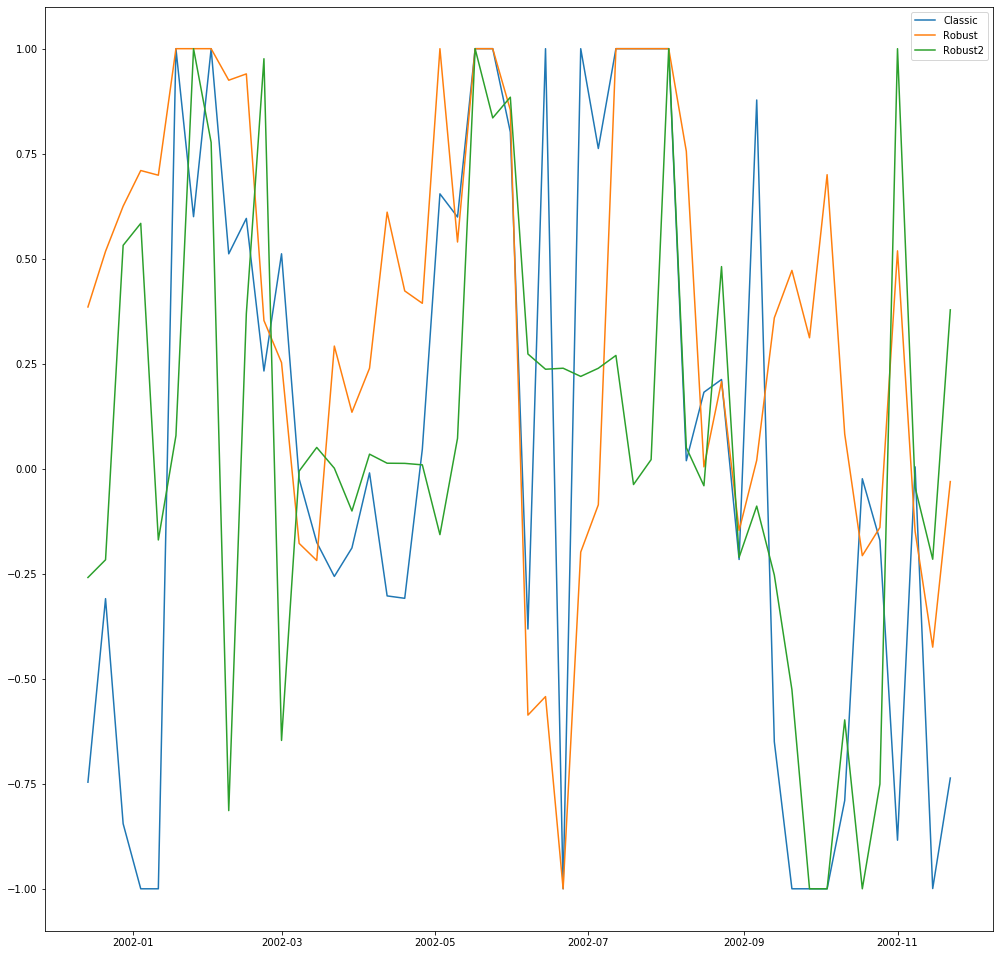

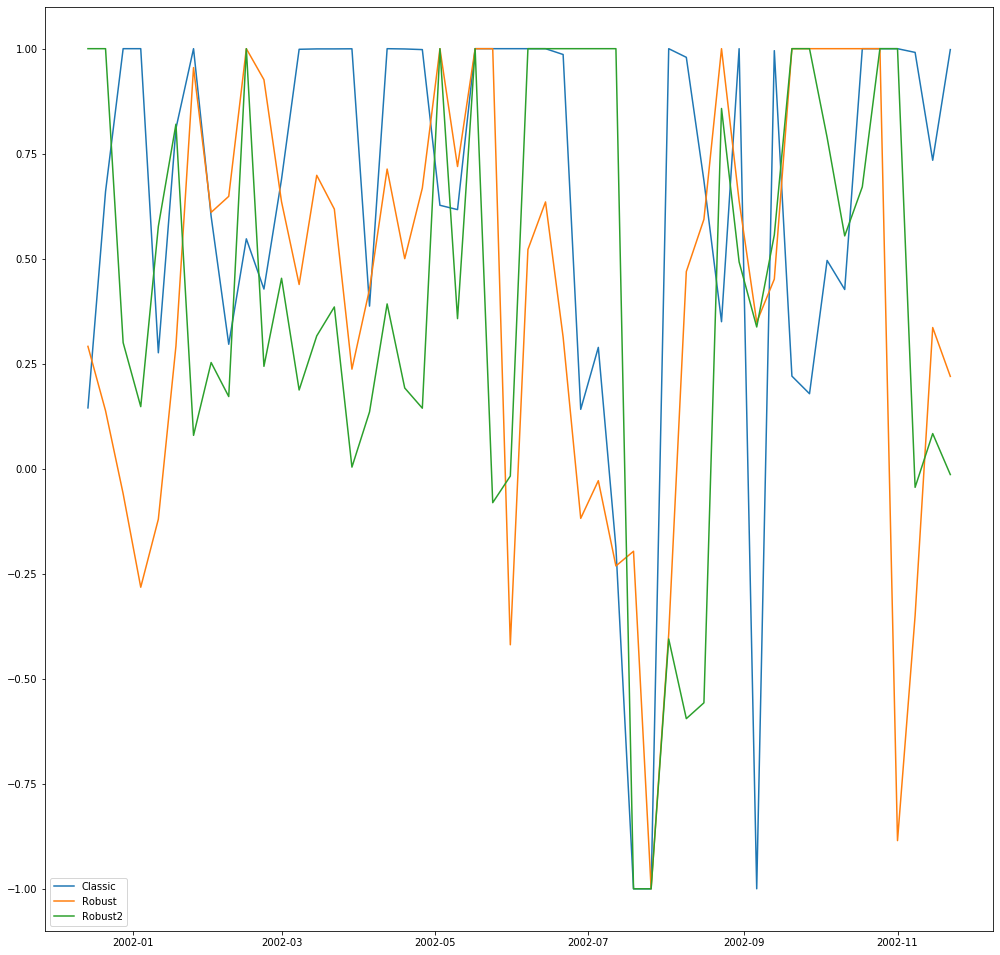

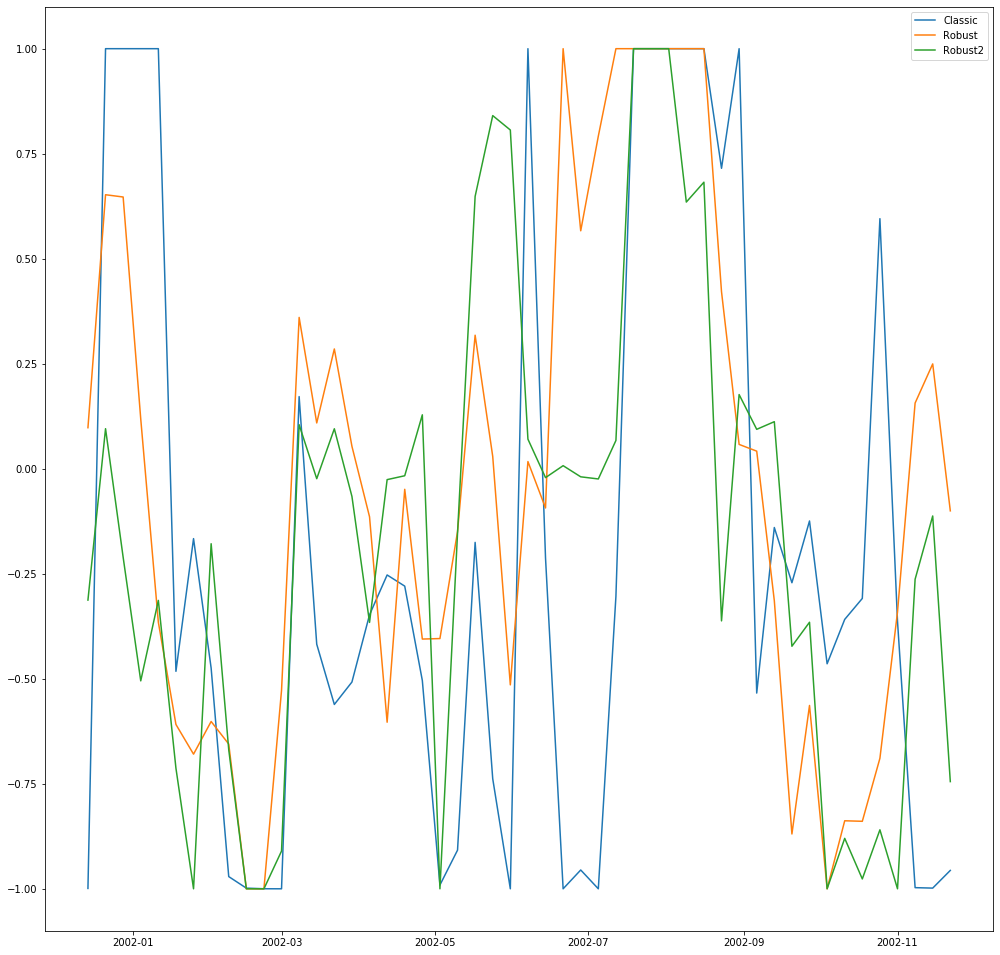

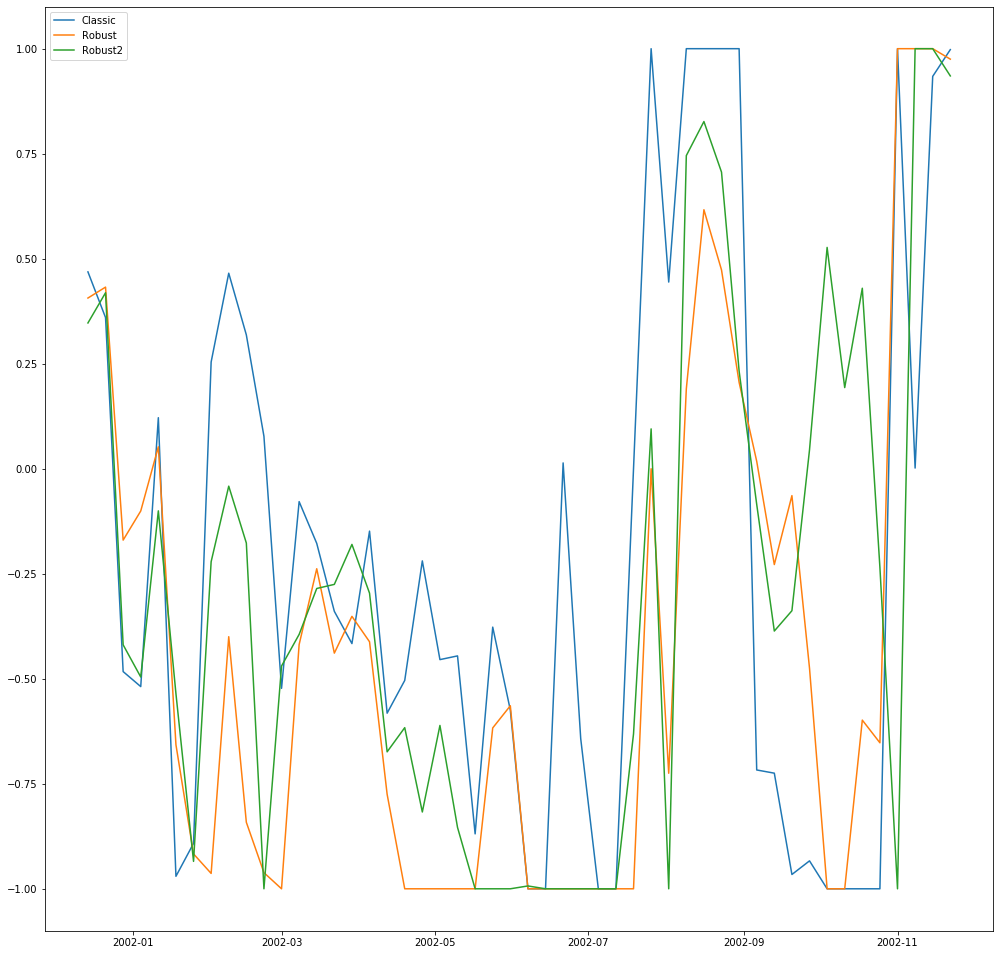

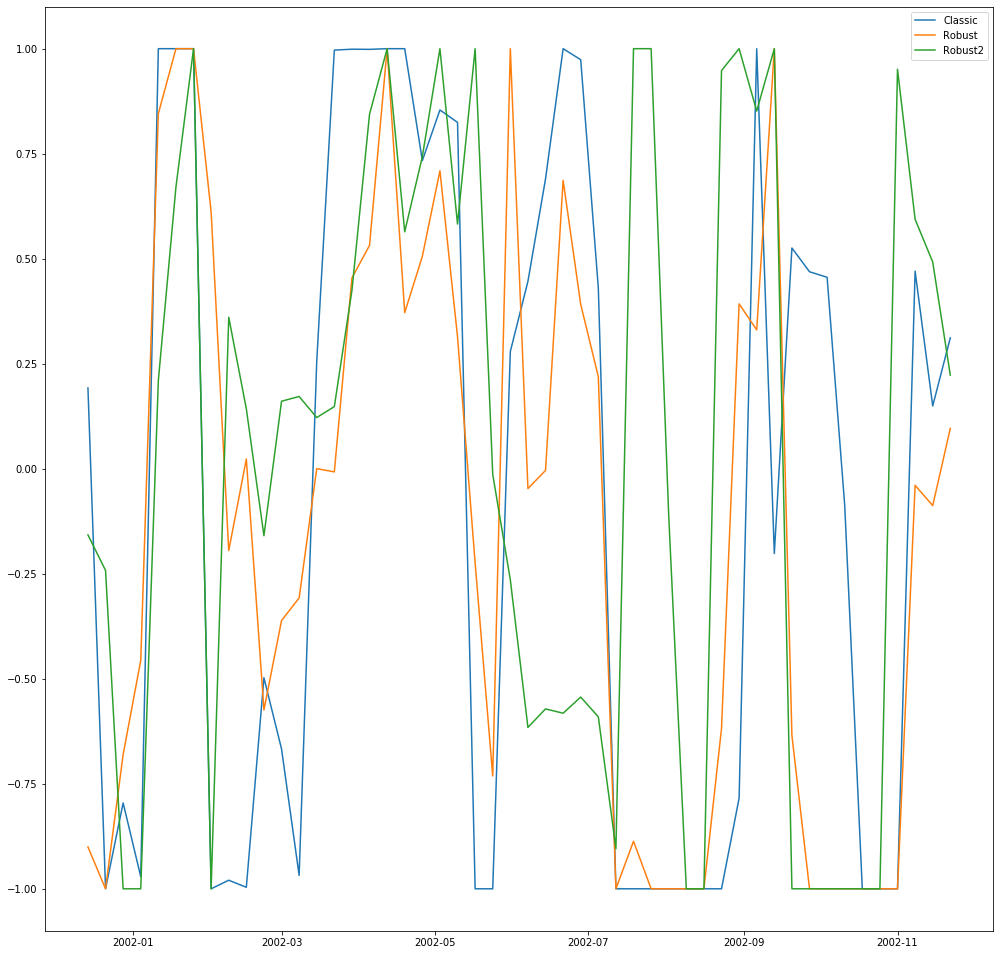

In [7]:
for asset in symbols:
    plt.figure(figsize=(17,17))
    plt.plot(WC[asset][100:150])
    plt.plot(WR[asset][100:150])
    plt.plot(WR2[asset][100:150])
    plt.legend(['Classic', 'Robust', 'Robust2'])
    plt.show()

## Comparison

In [8]:
Markowitz_Comparison = pd.DataFrame()
Markowitz_Comparison['Classic'] = Mark_Ret
Markowitz_Comparison['Robust'] = RMark_Ret
Markowitz_Comparison['Robust2'] = R2Mark_Ret
Markowitz_Comparison.index = Daily_Assets.index[the_start:]
Markowitz_Comparison = Markowitz_Comparison.astype(float)

In [9]:
Markowitz_Comparison.to_excel('Resultados 10k portafolios.xlsx')

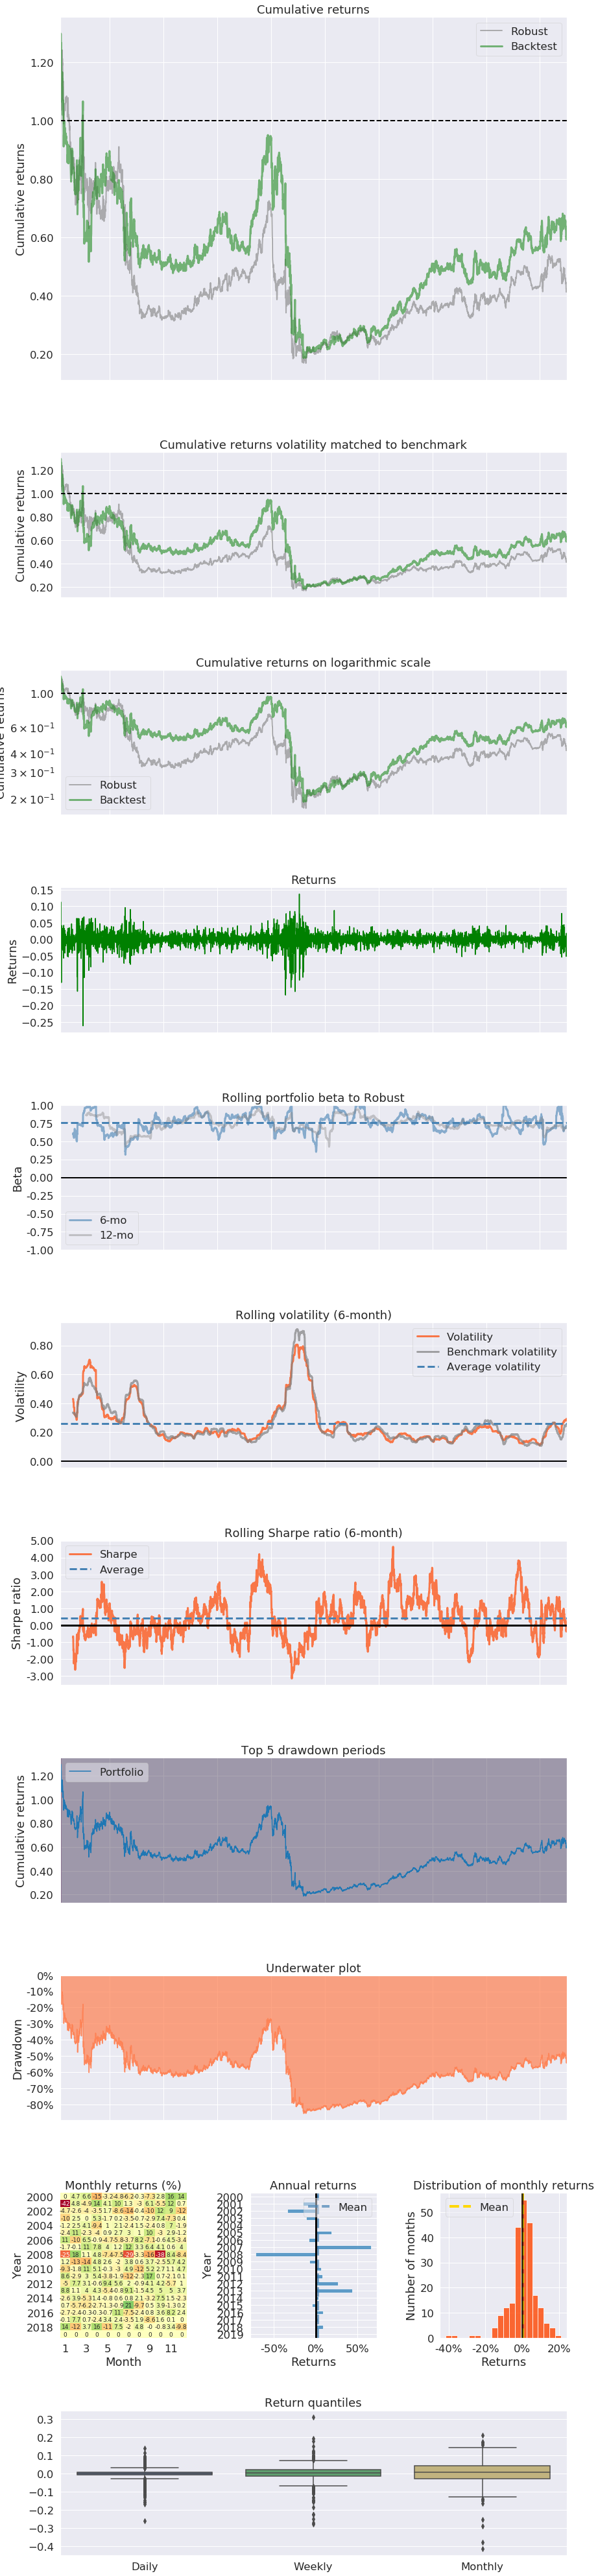

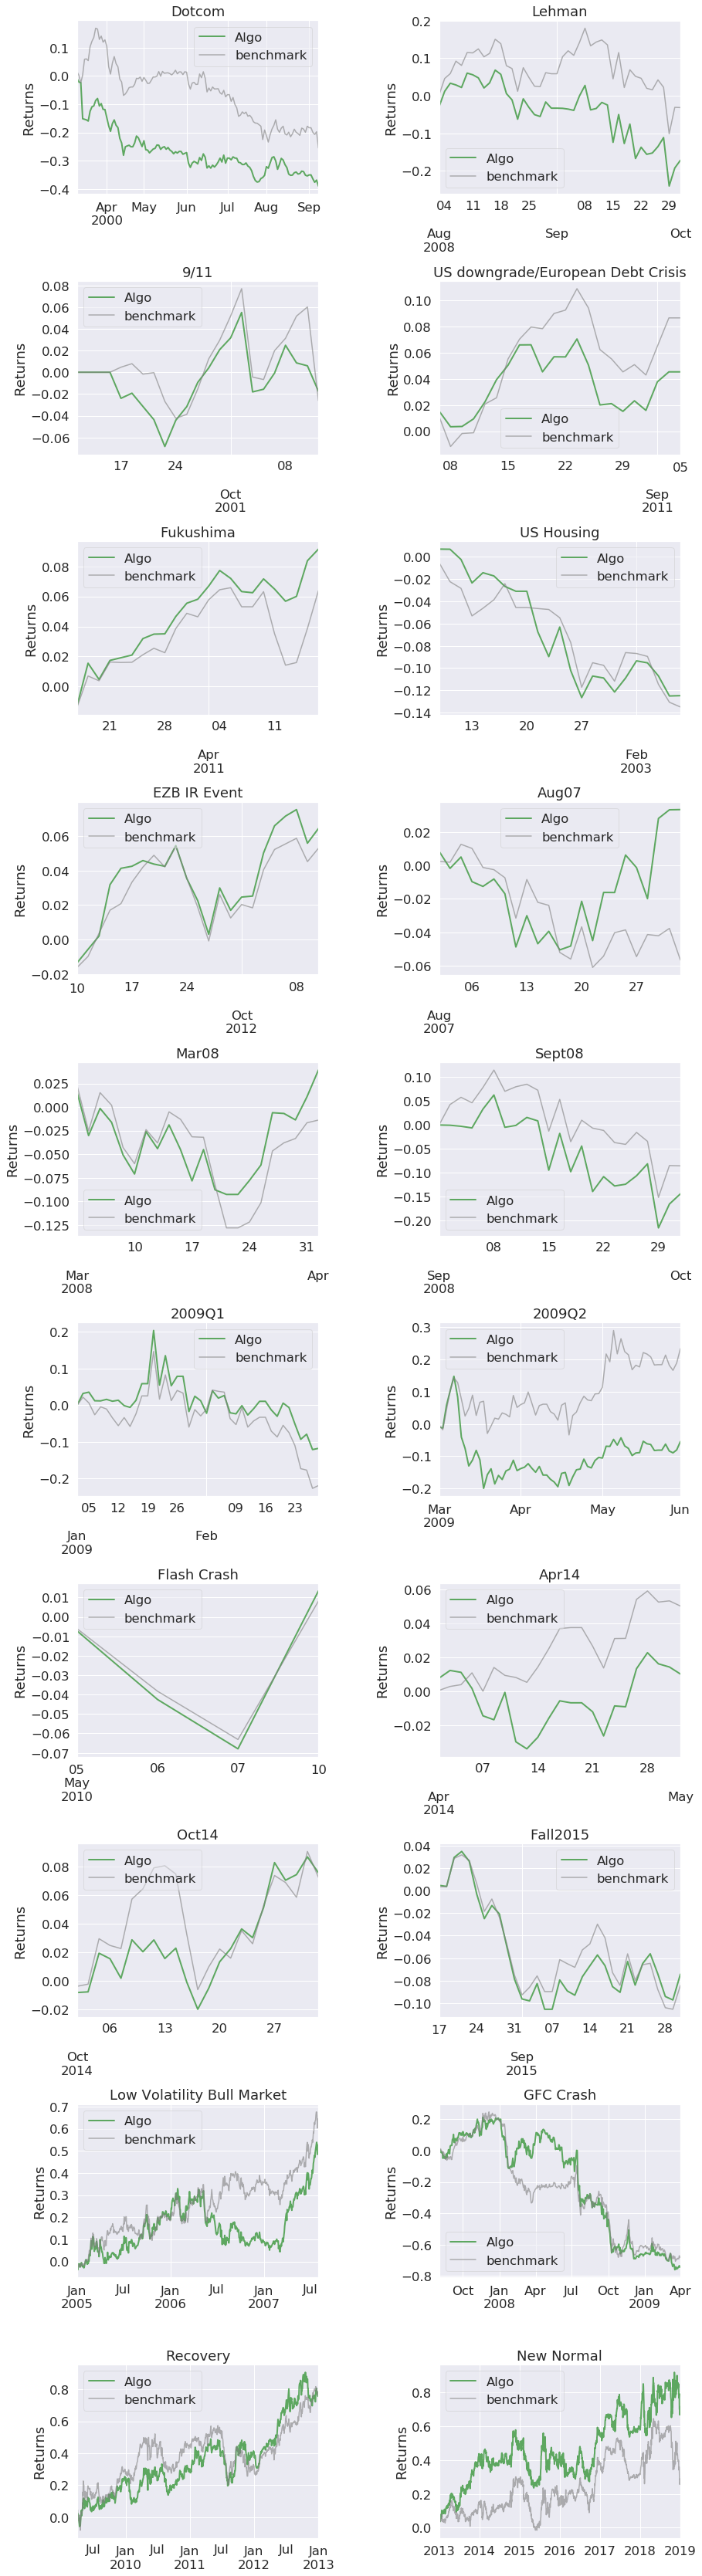

In [10]:
pyfolio.create_full_tear_sheet(Markowitz_Comparison['Robust2'], benchmark_rets=Markowitz_Comparison['Robust'])

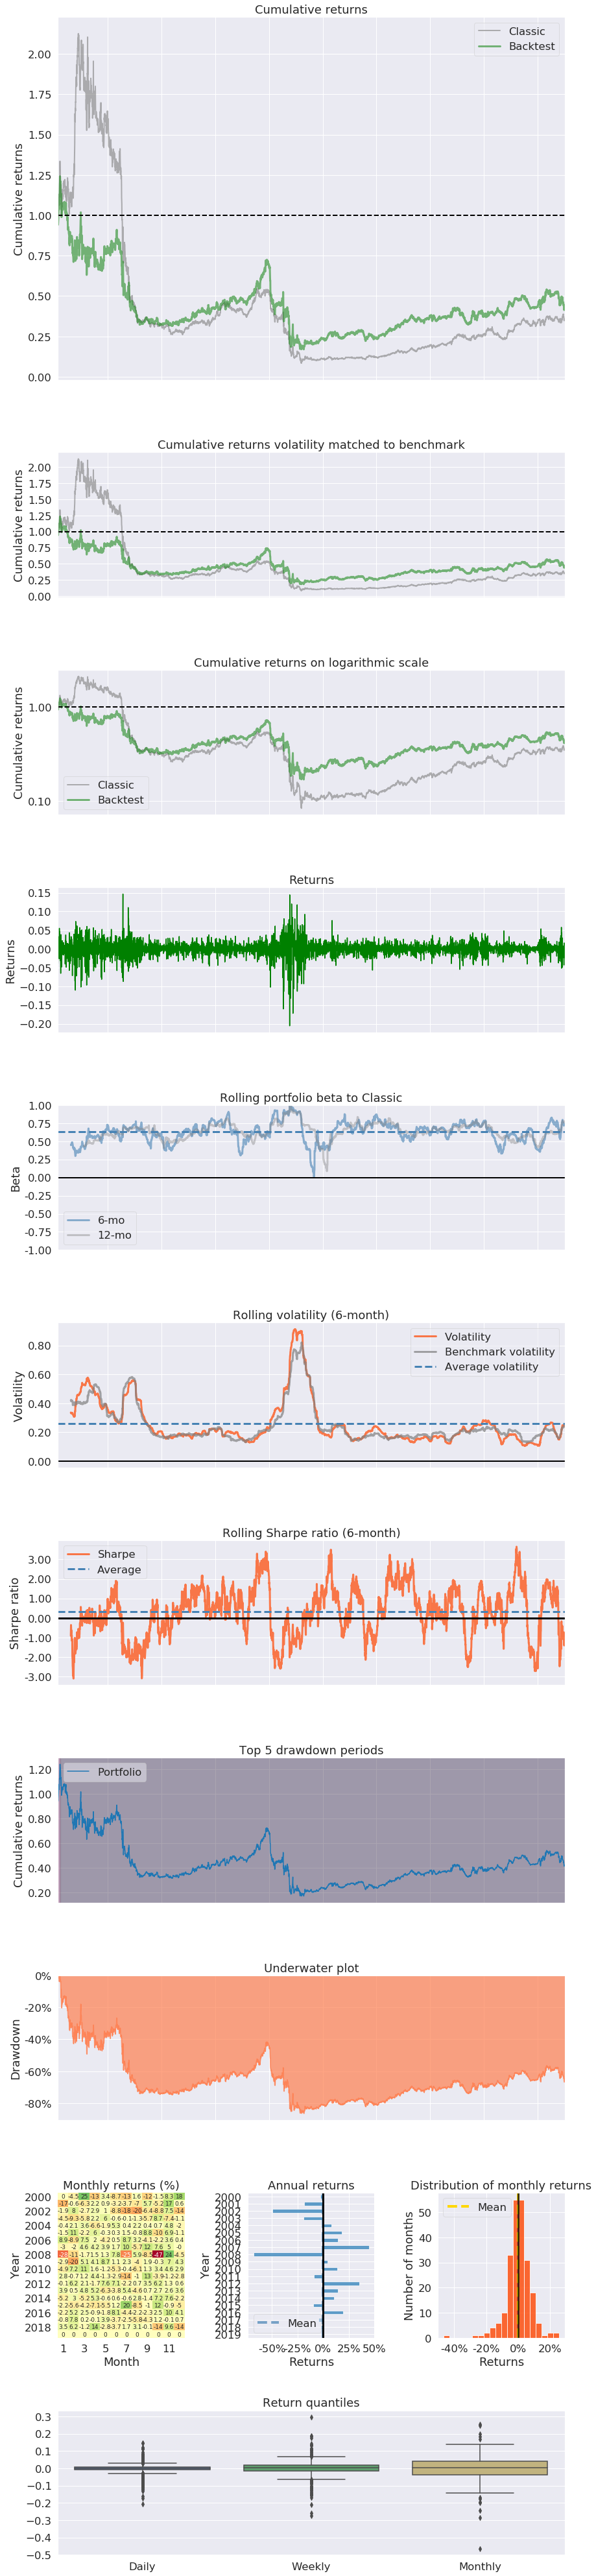

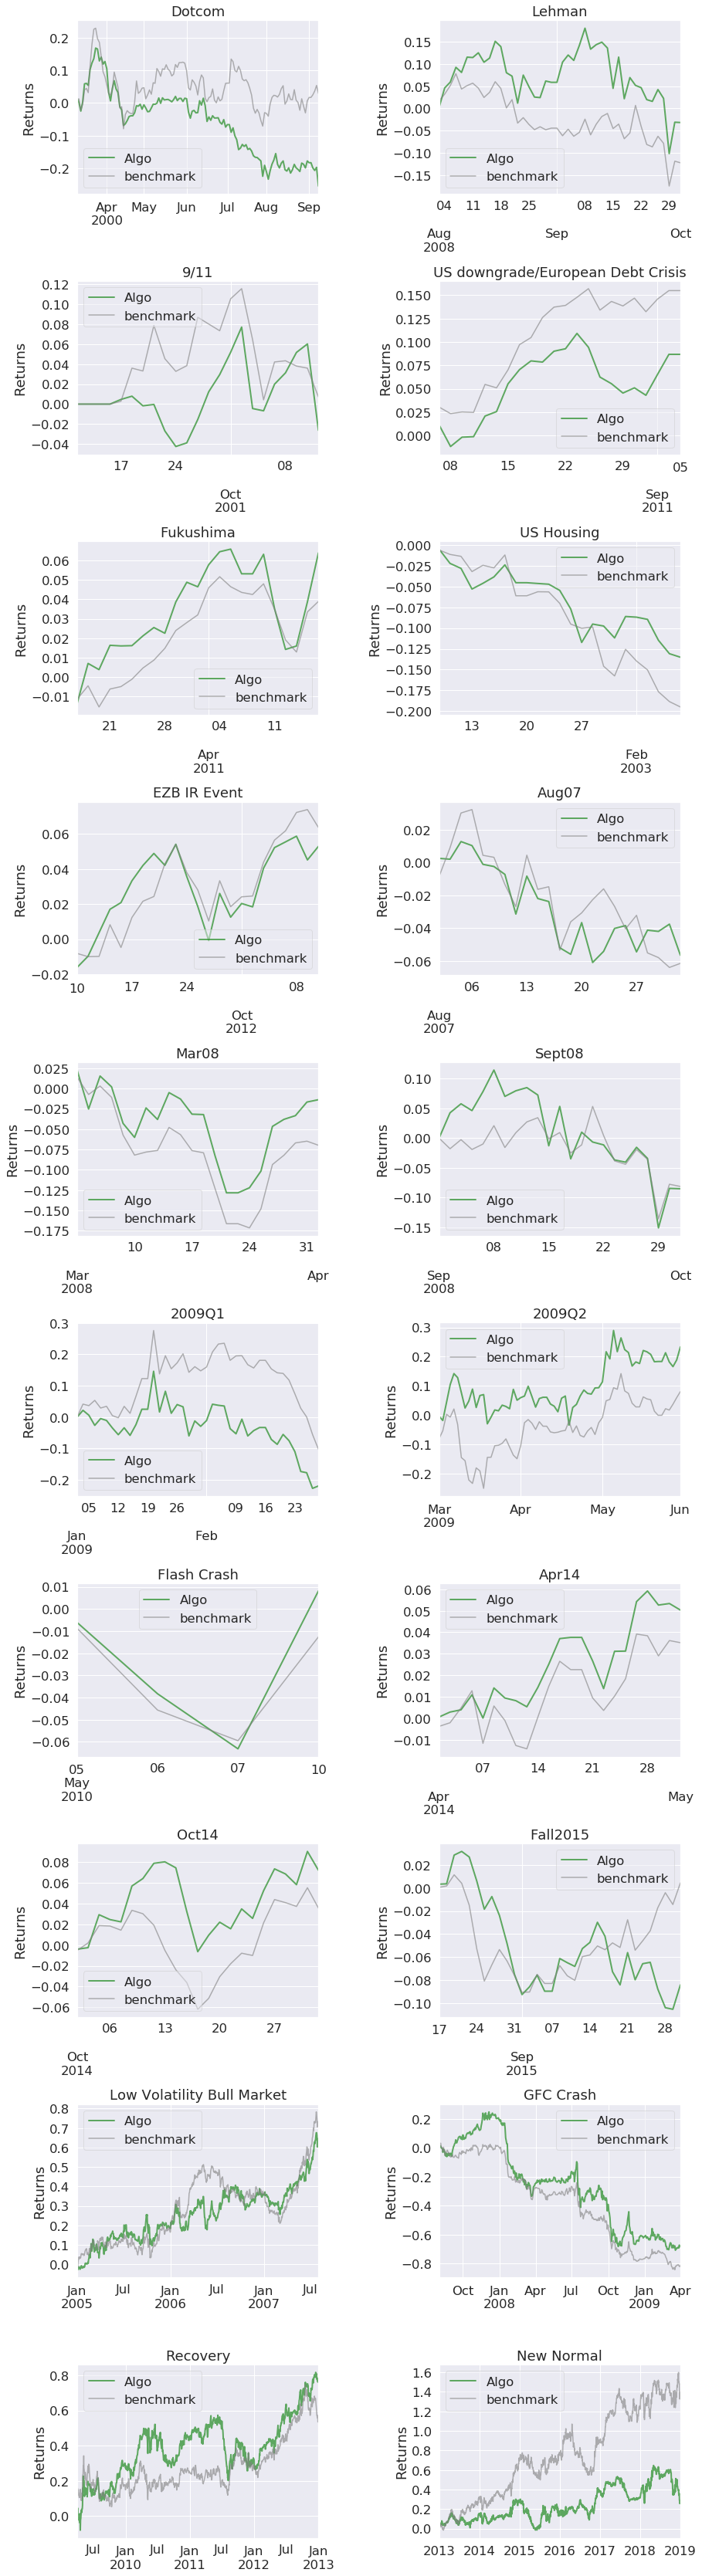

In [11]:
pyfolio.create_full_tear_sheet(Markowitz_Comparison['Robust'], benchmark_rets=Markowitz_Comparison['Classic'])

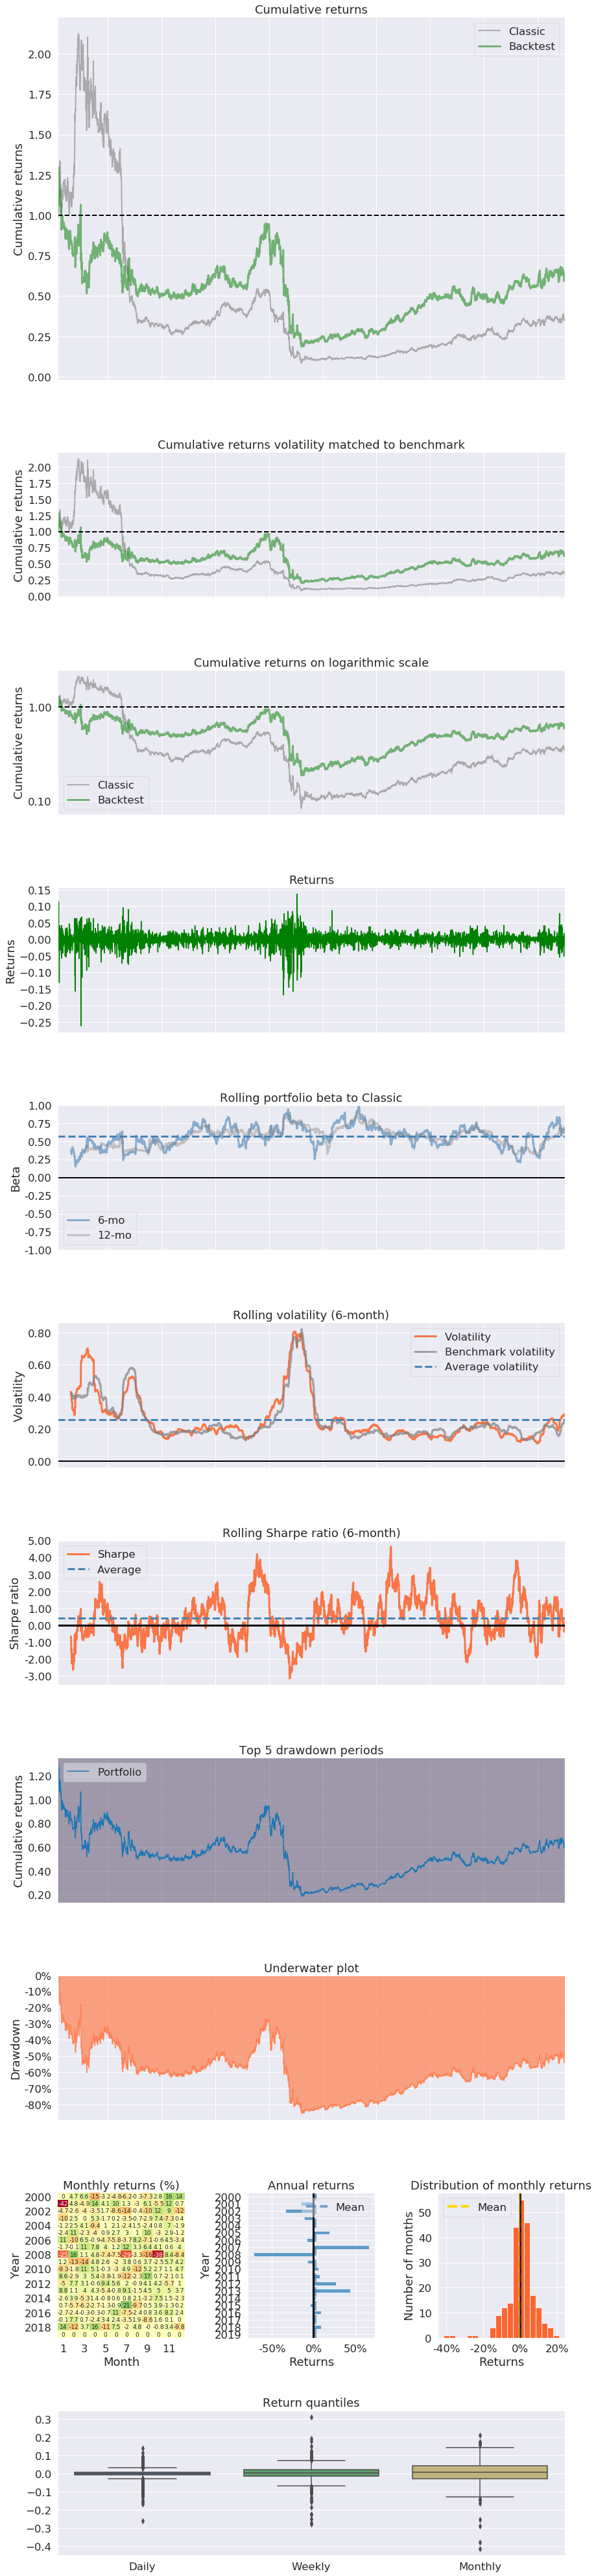

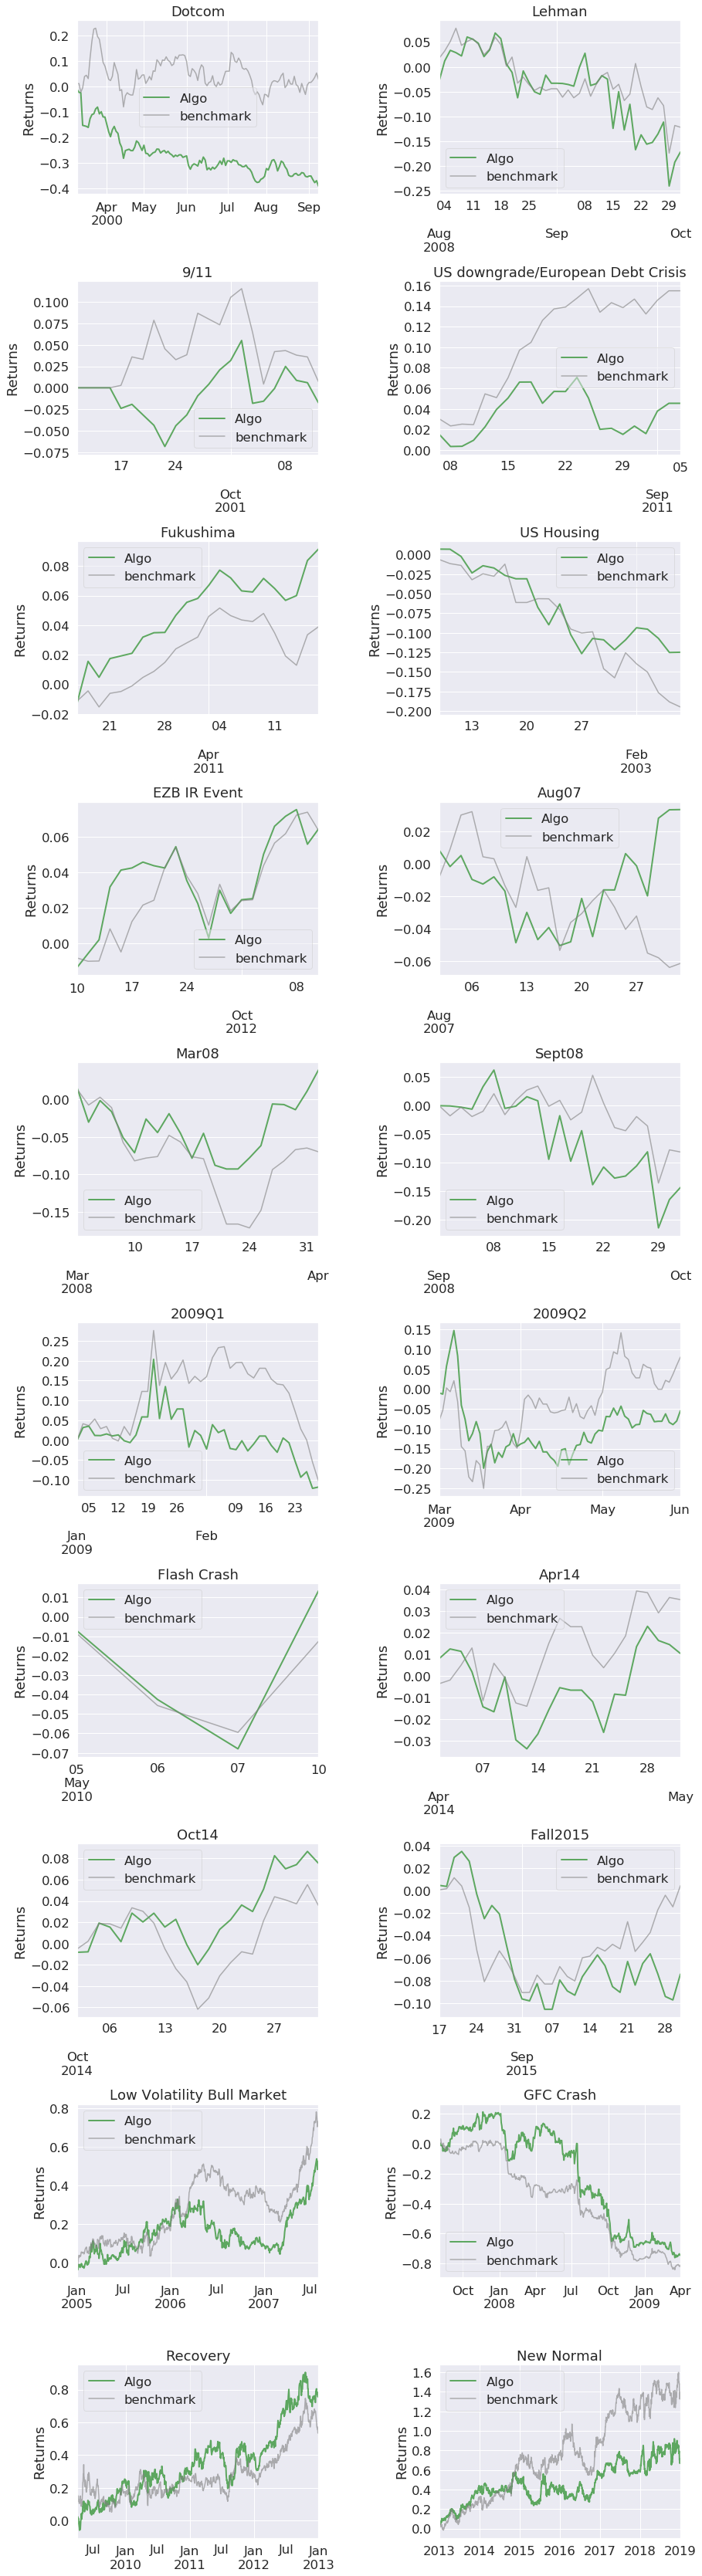

In [12]:
pyfolio.create_full_tear_sheet(Markowitz_Comparison['Robust2'], benchmark_rets=Markowitz_Comparison['Classic'])

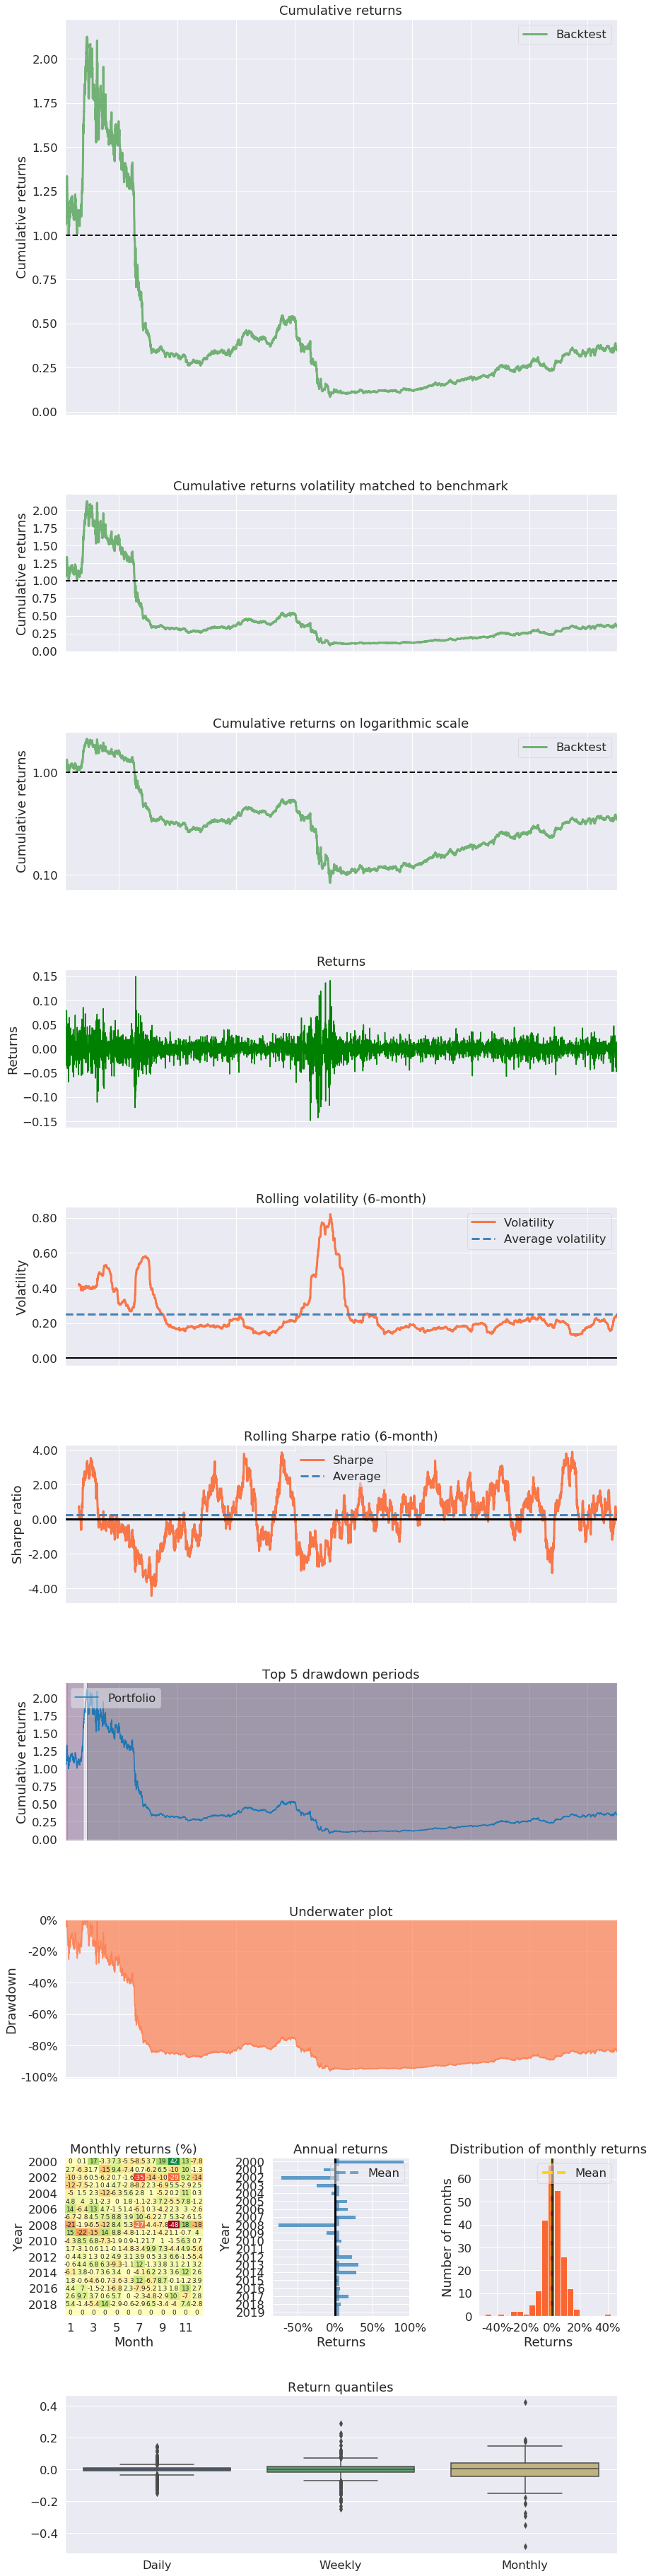

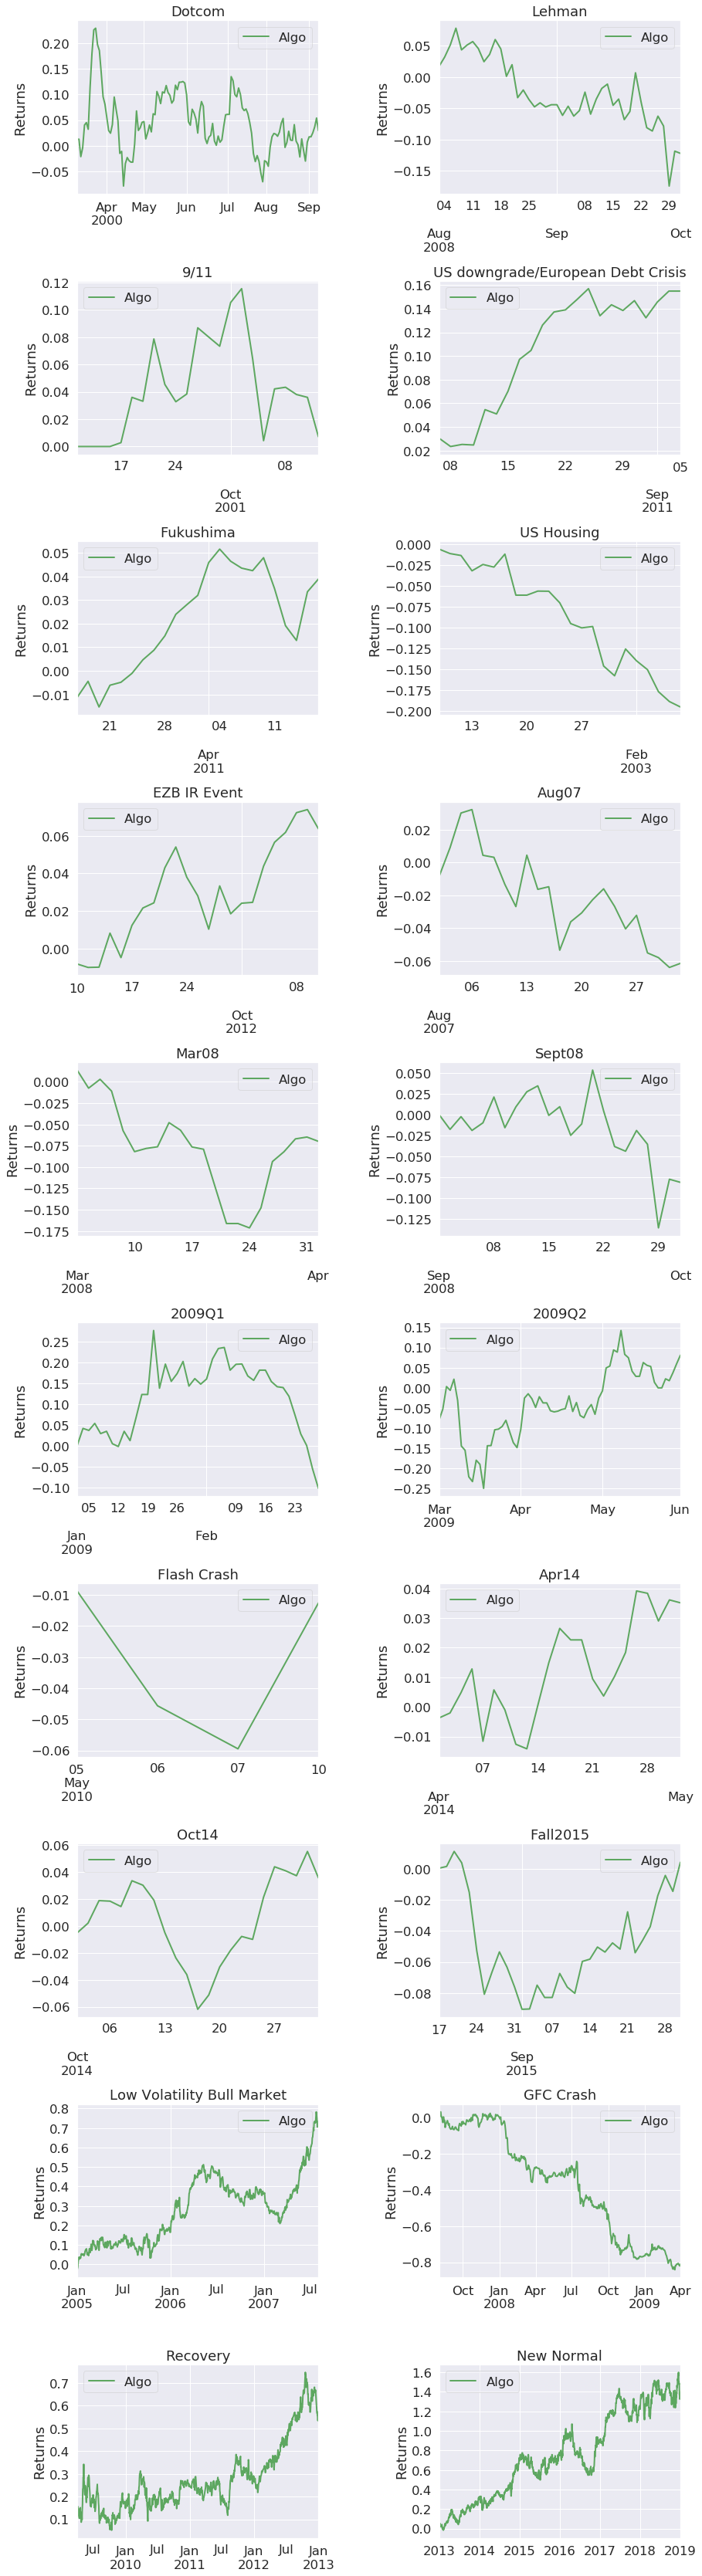

In [13]:
pyfolio.create_full_tear_sheet(Markowitz_Comparison['Classic'])#, benchmark_rets=Markowitz_Comparison['Classic'])